# Relax Inc.
Mock Take home challenge

Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven day
period , __identify which factors predict future user adoption .__

In [162]:
# Imports
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
print(pd.__version__)

from sklearn import __version__ as sklearn_version
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline

1.2.4


In [163]:
# Load data
user_visits = pd.read_csv("takehome_user_engagement.csv", parse_dates=True, infer_datetime_format=True)
user_data = pd.read_csv("takehome_users.csv", parse_dates=True, infer_datetime_format=True)

user_visits["time_stamp"] = pd.to_datetime(user_visits["time_stamp"], infer_datetime_format =True)

user_data["creation_time"] = pd.to_datetime(user_data["creation_time"], infer_datetime_format =True)
# convert unix datetime into pandas date time
user_data["last_session_creation_time"] = pd.to_datetime(user_data["last_session_creation_time"], unit='s')

print("user_visits")
display(user_visits.head())


print("user_data")
display(user_data.head())

user_visits


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


user_data


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0


## EDA

In [164]:
user_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [165]:
#Convert to date time object
user_data["last_session_creation_time"] = pd.to_datetime(user_data["last_session_creation_time"], unit='s')

user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 937.6+ KB


In [166]:
# Remove comment to run, this takes a little while, so I've turned it off 
#profile = ProfileReport(user_data, title="Pandas Profiling Report")
#profile.to_widgets()

In [167]:
#Confirm this column just contains '1'
user_visits.visited.value_counts()
#user_visits=user_visits.drop('visited', axis='columns')


1    207917
Name: visited, dtype: int64

<AxesSubplot:>

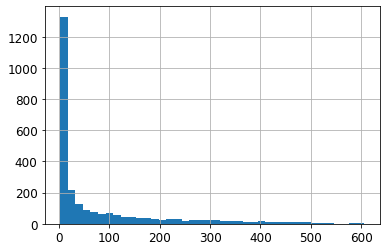

In [168]:
# Set time stamp as index
#visits per 7 dayy window by user
user_visits = user_visits.set_index('time_stamp')

visit_count = user_visits.groupby("user_id").count()
visit_count.visited[visit_count.visited > 1].hist(bins=40)

In [169]:
# Max visits by any user
user_visits.groupby("user_id").count().max()

visited    606
dtype: int64

In [170]:
user_visits

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1
...,...,...
2013-09-06 06:14:15,11996,1
2013-01-15 18:28:37,11997,1
2014-04-27 12:45:16,11998,1


In [171]:
# Get 7 day rolling sum
user_visits = user_visits.sort_values(['user_id','time_stamp'])
vists_per_7_days = user_visits.groupby('user_id').rolling('7D').sum()
vists_per_7_days=vists_per_7_days.drop("user_id", axis="columns")
#vists_per_7_days = pd.DataFrame(vists_per_7_days).droplevel(1).dropna()
vists_per_7_days.head(20)

visited
user_id time_stamp                  
1       2014-04-22 03:53:30      1.0
2       2013-11-15 03:45:04      1.0
        2013-11-29 03:45:04      1.0
        2013-12-09 03:45:04      1.0
        2013-12-25 03:45:04      1.0
        2013-12-31 03:45:04      2.0
        2014-01-08 03:45:04      1.0
        2014-02-03 03:45:04      1.0
        2014-02-08 03:45:04      2.0
        2014-02-09 03:45:04      3.0
        2014-02-13 03:45:04      3.0
        2014-02-16 03:45:04      2.0
        2014-03-09 03:45:04      1.0
        2014-03-13 03:45:04      2.0
        2014-03-31 03:45:04      1.0
3       2013-03-19 23:14:52      1.0
4       2013-05-22 08:09:28      1.0
5       2013-01-22 10:14:20      1.0
6       2013-12-19 03:37:06      1.0
7       2012-12-20 13:24:32      1.0

In [172]:
#join back to main dataset
vists_per_7_days = vists_per_7_days.groupby('user_id').visited.max()
user_data = pd.merge(user_data, vists_per_7_days, how='left', left_on=['object_id'], right_on=['user_id'])
user_data.set_index('object_id')

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,visited
object_id,,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,1.0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,3.0
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,1.0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,1.0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,1.0
...,...,...,...,...,...,...,...,...,...,...
11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,2013-09-06 06:14:15,0,0,89,8263.0,1.0
11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,2013-01-15 18:28:37,0,0,200,NaN,1.0
11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,2014-04-27 12:45:16,1,1,83,8074.0,1.0


In [173]:
# the target field
user_data["adopted_user"] = user_data.visited >= 3
user_data["adopted_user"].value_counts()

False    10398
True      1602
Name: adopted_user, dtype: int64

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


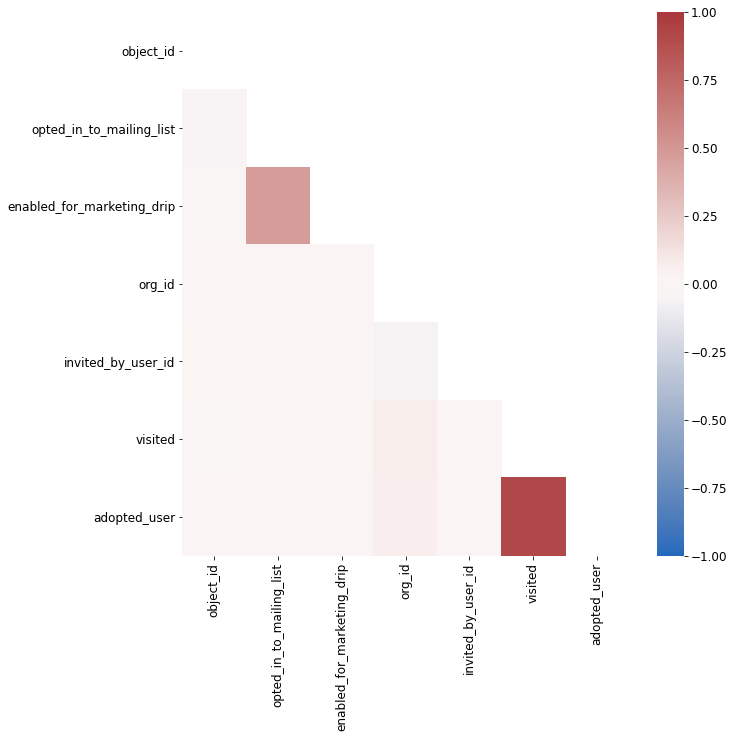

In [174]:
# fancy heatmap with mask to avoid duplicates
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
font = {'family' : 'ariel',
        'size'   : 12}
plt.rcParams.update({'font.size': 12})

mask = np.zeros_like(user_data.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(user_data.corr(), ax=ax, vmin=-1, vmax=1, cmap='vlag', mask=mask);

invited by user:
10741.0    13
2527.0     12
11770.0    11
1525.0     11
2308.0     11
           ..
5592.0      1
5289.0      1
3288.0      1
4467.0      1
10872.0     1
Name: invited_by_user_id, Length: 2564, dtype: int64

Org ID


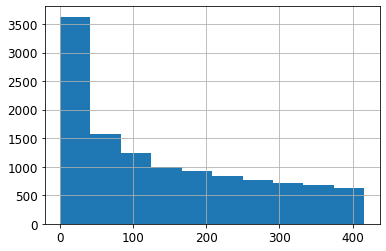

In [175]:

print("invited by user:")
print(user_data.invited_by_user_id.value_counts())

print("\nOrg ID")
user_data.org_id.hist();

## ML models

In [176]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
 10  visited                     8823 non-null   float64       
 11  adopted_user                12000 non-null  bool      

In [177]:
X = user_data.drop(['visited', 'adopted_user'], axis='columns')
y = user_data.adopted_user

In [178]:
X = X.drop(['name', 'email'], axis='columns')
X.head()

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
3,4,2013-05-21 08:09:28,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
4,5,2013-01-17 10:14:20,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0


### Feature Eng
 - one hot encode creation_source, org_id
 - convert "invited_by_user_id" to be bool 'was_invited_by_user'
 - convert 'last_session_creation_time' to 'day used since creation time' and 'have_used_since_creation'

In [179]:
# Convert "invited_by_user_id" to be bool 'invited_by_user'
X['was_invited_by_user'] = X.invited_by_user_id.notnull()

#convert 'last_session_creation_time' to 'day used since creation time' and 'have_used_since_creation'
X['have_used_since_creation'] = X.last_session_creation_time.notnull()

X['creation_minus_last_active_date_as_days'] = (X.last_session_creation_time - X.creation_time).dt.days

#Drop the old ones
X = X.drop(['invited_by_user_id', 'creation_time', 'last_session_creation_time', 'object_id'], axis='columns')

In [182]:
X = X.fillna(0)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 7 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   creation_source                          12000 non-null  object 
 1   opted_in_to_mailing_list                 12000 non-null  int64  
 2   enabled_for_marketing_drip               12000 non-null  int64  
 3   org_id                                   12000 non-null  int64  
 4   was_invited_by_user                      12000 non-null  bool   
 5   have_used_since_creation                 12000 non-null  bool   
 6   creation_minus_last_active_date_as_days  12000 non-null  float64
dtypes: bool(2), float64(1), int64(3), object(1)
memory usage: 585.9+ KB


In [183]:
# One hot encode categories
X = pd.get_dummies(X,prefix="source_", dummy_na="no_org")
X = pd.get_dummies(X,prefix="org_ID_", dummy_na="no_org", columns=['org_id'])

X.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,was_invited_by_user,have_used_since_creation,creation_minus_last_active_date_as_days,source__GUEST_INVITE,source__ORG_INVITE,source__PERSONAL_PROJECTS,source__SIGNUP,source__SIGNUP_GOOGLE_AUTH,...,org_ID__408.0,org_ID__409.0,org_ID__410.0,org_ID__411.0,org_ID__412.0,org_ID__413.0,org_ID__414.0,org_ID__415.0,org_ID__416.0,org_ID__nan
0,1,0,True,True,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,True,True,136.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,True,True,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,True,True,1.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,True,True,5.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [184]:
X.shape

(12000, 429)

### Modeling

In [185]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, test_size=0.2, 
                                                    random_state=42)

In [186]:
## Random Forest

In [187]:
RFclass = RandomForestClassifier(random_state=42)  #Set up above

grid_params_rf = {'randomforestclassifier__min_samples_split': np.arange(2,12),
                  'randomforestclassifier__n_estimators': np.arange(10,500,5)
              }
rfPipe = make_pipeline(RFclass)

#Random search through parameters + cross validation
rfRandSearch = RandomizedSearchCV(rfPipe, param_distributions=grid_params_rf, n_jobs=-1, n_iter=10)


In [188]:
%%time
rfRandSearch.fit(X_train, y_train)

y_tr_rf = rfRandSearch.predict(X_train)
y_te_rf = rfRandSearch.predict(X_test)
rfRandSearch.best_params_

Wall time: 2min 34s


{'randomforestclassifier__n_estimators': 30,
 'randomforestclassifier__min_samples_split': 7}

In [192]:
# Print scores
print("Train score:", rfRandSearch.score(X_train, y_train))
print("Test score:", rfRandSearch.score(X_test, y_test))


Train score: 0.989375
Test score: 0.9770833333333333


In [191]:
rfRandSearch.best_params_['randomforestclassifier__n_estimators']

30

In [193]:
#Check feature importance
best_n_est = rfRandSearch.best_params_['randomforestclassifier__n_estimators']
best_min_samples_split = rfRandSearch.best_params_['randomforestclassifier__min_samples_split']
RF_best = RandomForestClassifier(random_state = 42,
                                 n_estimators = best_n_est, 
                                 min_samples_split = best_min_samples_split)


#After Jason Brownlee -  https://machinelearningmastery.com/calculate-feature-importance-with-python/
RF_best.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=7, n_estimators=30, random_state=42)

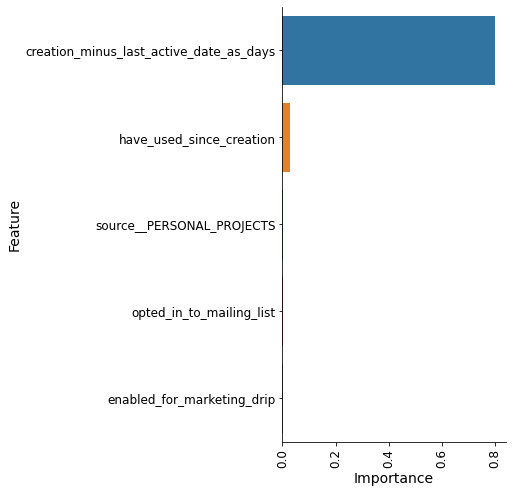

In [251]:



#print("Top 5 features", feat_importance[0:5])

#Show all
#feat_importance_df = pd.DataFrame(feat_importance, columns = ["Feature", "Importance"]) 
def plot_rf_feat_importance(RF_best, X_train, top_n=5, start_n=0 ):
    importance = RF_best.feature_importances_
    x_features = X_train.columns
    
    # summarize feature importance
    feat_importance = list(zip(x_features, importance))
    feat_importance = sorted(feat_importance,key=lambda x: abs(x[1]), reverse=True)
    
    #Show top_n
    feat_importance_df = pd.DataFrame(feat_importance[start_n:top_n], columns = ["Feature", "Importance"]) 


    # plot feature importance
    #px.bar(data_frame = feat_importance_df, x = "Feature", y = "Importance", color= "Importance")
    fig, ax = plt.subplots(figsize=(4,8))
    sns.barplot(data= feat_importance_df, y = "Feature", x = "Importance", orient='h')
    plt.ylabel("Feature", size=14)
    plt.xlabel("Importance", size=14)
    plt.xticks(rotation=90)
    sns.despine();
plot_rf_feat_importance(RF_best, X_train)

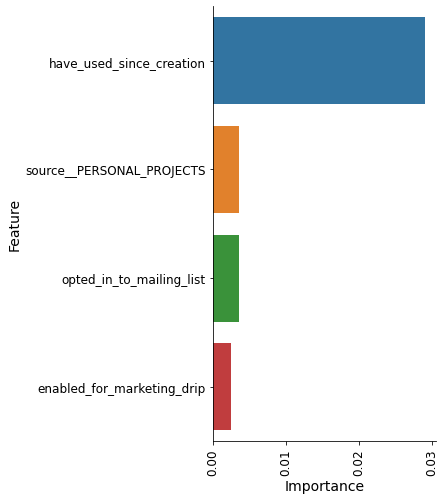

In [252]:
plot_rf_feat_importance(RF_best, X_train, top_n=5, start_n=1)

In [ ]:
# join X and Y back with feature engineering and check the correlation
eng_user_data = pd.merge(X, y, how='left', left_index=True, right_index=True)


Text(0.5, 0, 'Adopted user?')

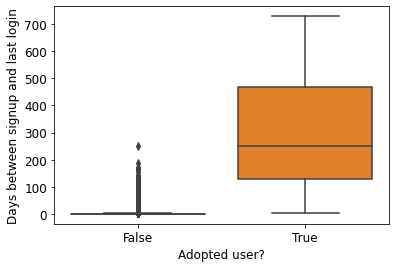

In [248]:
sns.boxplot(y='creation_minus_last_active_date_as_days',x='adopted_user', data=eng_user_data);
plt.ylabel('Days between signup and last login')
plt.xlabel('Adopted user?')

0.6427796822789339

([<matplotlib.axis.YTick at 0x2892c769e48>,
 [Text(0, -0.1, 'No'), Text(0, 0.9, 'Yes')])

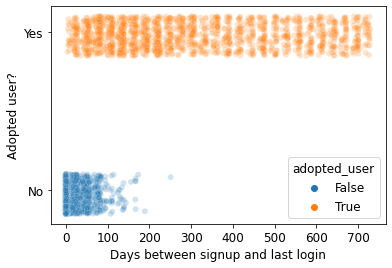

In [246]:
import random
x = eng_user_data.creation_minus_last_active_date_as_days
y= eng_user_data.adopted_user.astype(float)
y = [i+random.random()/4-0.25 for i in y]
sns.scatterplot(x=x ,y=y,
                alpha =0.2,
                hue='adopted_user', data=eng_user_data)
plt.xlabel('Days between signup and last login')
plt.ylabel('Adopted user?')
plt.yticks(ticks=[-0.1,.9], labels=["No", "Yes"])

0        0
1        1
2        0
3        0
4        0
        ..
11995    0
11996    0
11997    0
11998    0
11999    0
Name: adopted_user, Length: 12000, dtype: int32

## Summary